In [109]:
import mingpt
from mingpt.prisonerTrainer import PrisonerTrainer
from mingpt.model import GPT
from torchinfo import summary
import torch

In [110]:
model_config = GPT.get_default_config()
model_config.model_type = 'gpt-pico'
model_config.vocab_size = 2
model_config.block_size = 128
model_config.alg_name = "actde"
model_config.detach_head = False
model = GPT(model_config)
firstTokenSampler = torch.distributions.bernoulli.Bernoulli(probs=torch.tensor([0.5]))
input_ids = firstTokenSampler.sample(sample_shape=(1,)).long().to("cuda")
summary(model)

# print(model)

number of parameters: 0.01M


Layer (type:depth-idx)                             Param #
GPT                                                --
├─ModuleDict: 1-1                                  --
│    └─Embedding: 2-1                              24
│    └─Embedding: 2-2                              1,536
│    └─Dropout: 2-3                                --
│    └─ModuleList: 2-4                             --
│    │    └─Block: 3-1                             1,884
│    │    └─Block: 3-2                             1,884
│    │    └─Block: 3-3                             1,884
│    └─LayerNorm: 2-5                              24
├─Linear: 1-2                                      24
├─Linear: 1-3                                      13
├─Linear: 1-4                                      26
Total params: 7,299
Trainable params: 7,299
Non-trainable params: 0

In [111]:
train_config = PrisonerTrainer.get_default_config()
train_config.learning_rate = 5e-4 # many possible options, see the file
train_config.max_iters = 500
train_config.gamma = 0.50
train_config.alg_name = model_config.alg_name
train_config.whiten = True
train_config.vf_loss_type = "ppo"
trainer = PrisonerTrainer(train_config, model)
print(trainer.equilibriumDiscount(startCoop=True), trainer.equilibriumDiscount(startCoop=False))
print(0.5 * trainer.equilibriumDiscount(startCoop=True) + 0.5 * trainer.equilibriumDiscount(startCoop=False))

stats_filename = "rewStatsPPO.json"
model_filename = "modelPPO.pt"

running on device cuda
tensor(0.5477) tensor(0.4523)
tensor(0.5000)


In [98]:
trainer.run(stats_filename=stats_filename, model_filename=model_filename)

 iter  500 / 50000 83 / 500/ 500 500 216 / 500/ 500 332 / 500

In [101]:
for i in range(0, 10):
    model_config = GPT.get_default_config()
    model_config.model_type = 'gpt-pico'
    model_config.vocab_size = 2
    model_config.block_size = 128
    model_config.alg_name = "actde"
    model_config.detach_head = False
    model = GPT(model_config)
    firstTokenSampler = torch.distributions.bernoulli.Bernoulli(probs=torch.tensor([0.5]))
    input_ids = firstTokenSampler.sample(sample_shape=(1,)).long().to("cuda")
    summary(model)

    train_config = PrisonerTrainer.get_default_config()
    train_config.learning_rate = 5e-4 # many possible options, see the file
    train_config.max_iters = 10000
    train_config.gamma = 0.50
    train_config.alg_name = model_config.alg_name
    train_config.whiten = True
    train_config.vf_loss_type = "ppo"
    trainer = PrisonerTrainer(train_config, model)
    print(trainer.equilibriumDiscount(startCoop=True), trainer.equilibriumDiscount(startCoop=False))
    print(0.5 * trainer.equilibriumDiscount(startCoop=True) + 0.5 * trainer.equilibriumDiscount(startCoop=False))

    stats_filename = f"rewStats-whiten-t{i}.json"
    model_filename = f"model-whiten-t{i}.pt"

    print("trial", i)
    trainer.run(stats_filename=stats_filename, model_filename=model_filename)

number of parameters: 0.01M
running on device cuda
tensor(0.5477) tensor(0.4523)
tensor(0.5000)
trial 0
 iter  500 / 500number of parameters: 0.01M
running on device cuda
tensor(0.5477) tensor(0.4523)
tensor(0.5000)
trial 1
 iter  500 / 500number of parameters: 0.01M
running on device cuda
tensor(0.5477) tensor(0.4523)
tensor(0.5000)
trial 2
 iter  172 / 500 500/ 500

KeyboardInterrupt: 

In [45]:
colors = {}
colors["alternating"] = "green"
colors["coop-coop"] = "blue"
colors["defect-defect"] = "red"

# discounted returns for discount rate 0.5 and matrix [[0.5, -1.76139], [2, -0.738613]]
# cccc = 1
# cddd = 1.261
# cdcd = 1.492
# dddd = -1.477
# dccc = -1.261
# dcdc = -1.015

gamma_ = 0.5
print("payoff matrix")
print(trainer.payOffMat())
print("discount rate thresholds, coop - defect - mean")
print(trainer.equilibriumDiscount(startCoop=True).item(), trainer.equilibriumDiscount(startCoop=False).item(), 
      (0.5 * trainer.equilibriumDiscount(startCoop=True) + 0.5 * trainer.equilibriumDiscount(startCoop=False)).item())

print(f"discounted returns for discount rate {gamma_}")
cccc = torch.zeros(1, 128).long()
cccc = trainer.discountSum(trainer.getRewards(cccc), gamma_)[0].item()

cddd = torch.ones(1, 128).long()
cddd[:, 0] = 0
cddd = trainer.discountSum(trainer.getRewards(cddd), gamma_)[0].item()

cdcd = torch.ones(1, 128).long()
cdcd[:, ::2] = 0
cdcd = trainer.discountSum(trainer.getRewards(cdcd), gamma_)[0].item()

dddd = torch.ones(1, 128).long()
dddd = trainer.discountSum(trainer.getRewards(dddd), gamma_)[0].item()

dccc = torch.zeros(1, 128).long()
dccc[:, 0] = 1
dccc = trainer.discountSum(trainer.getRewards(dccc), gamma_)[0].item()

dcdc = torch.zeros(1, 128).long()
dcdc[:, ::2] = 1
dcdc = trainer.discountSum(trainer.getRewards(dcdc), gamma_)[0].item()

print("cccc", "cddd", "cdcd")
print(cccc, cddd, cdcd)
print("dccc", "dddd", "dcdc")
print(dccc, dddd, dcdc)

accc = (cccc + dccc) / 2
addd = (cddd + dddd) / 2
acdc = (cdcd + dcdc) / 2

print("accc", "addd", "acdc")
print(accc, addd, acdc)
softmax_returns = torch.nn.functional.softmax(torch.tensor([accc, addd, acdc]))
print("softmax returns")
print(softmax_returns)

payoff matrix
tensor([[ 0.5000, -1.7614],
        [ 2.0000, -0.7386]])
discount rate thresholds, coop - defect - mean
0.5477225184440613 0.4522780179977417 0.5000002384185791
discounted returns for discount rate 0.5
cccc cddd cdcd
1.0 1.2613869905471802 1.4924066066741943
dccc dddd dcdc
-1.261389970779419 -1.47722589969635 -1.0151865482330322
accc addd acdc
-0.13069498538970947 -0.10791945457458496 0.23861002922058105
softmax returns
tensor([0.2882, 0.2948, 0.4170])


C:\Users\Michael Einhorn\AppData\Local\Temp\ipykernel_1032\846011780.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_returns = torch.nn.functional.softmax(torch.tensor([accc, addd, acdc]))


In [105]:
# plot of single run

trial_num = 1
stats_filename = f"rewStats-t{trial_num}.json"

import json
with open("stats/" + stats_filename, 'r') as file:
    iter_list, rew_dict, avg_rets, loss_list = json.load(file)
print(iter_list, rew_dict, avg_rets)

rew_vals = sorted([float(r) for r in rew_dict.keys()])
print(rew_vals)

rew_dict_named = {}
total = 0
for f in rew_dict.values():
    total += f[0]
print(total)

rew_dict_named["alternating"] = [(rew_dict[str(rew_vals[0])][i] + rew_dict[str(rew_vals[3])][i]) / total for i in range(len(iter_list))]
rew_dict_named["coop-coop"] = [rew_dict[str(rew_vals[2])][i] / total for i in range(len(iter_list))]
rew_dict_named["defect-defect"] = [rew_dict[str(rew_vals[1])][i] / total for i in range(len(iter_list))]




[0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96, 100, 104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156, 160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200, 204, 208, 212, 216, 220, 224, 228, 232, 236, 240, 244, 248, 252, 256, 260, 264, 268, 272, 276, 280, 284, 288, 292, 296, 300, 304, 308, 312, 316, 320, 324, 328, 332, 336, 340, 344, 348, 352, 356, 360, 364, 368, 372, 376, 380, 384, 388, 392, 396, 400, 404, 408, 412, 416, 420, 424, 428, 432, 436, 440, 444, 448, 452, 456, 460, 464, 468, 472, 476, 480, 484, 488, 492, 496, 500, 504, 508, 512, 516, 520, 524, 528, 532, 536, 540, 544, 548, 552, 556, 560, 564, 568, 572, 576, 580, 584, 588, 592, 596, 600, 604, 608, 612, 616, 620, 624, 628, 632, 636, 640, 644, 648, 652, 656, 660, 664, 668, 672, 676, 680, 684, 688, 692, 696, 700, 704, 708, 712, 716, 720, 724, 728, 732, 736, 740, 744, 748, 752, 756, 760, 764, 768, 772, 776, 780, 784, 788, 792, 796, 800, 804, 808, 812, 816, 82

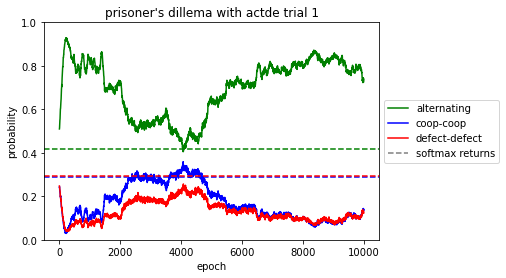

In [114]:
import matplotlib.pyplot as plt
import numpy as np

minEp = 0
maxEp = 6400
stride = 1

alg_name = train_config.alg_name
if alg_name == "reject":
    alg_name = "rejection sampling"

plt.figure()
title = f"prisoner's dillema with {alg_name} trial {trial_num}"
plt.title(title)
plt.ylabel("probability")
plt.xlabel("epoch")
for k in rew_dict_named:
    plt.plot(iter_list[minEp:maxEp:stride], rew_dict_named[k][minEp:maxEp:stride], label=k, color=colors[k], marker="")

# horizontal dashed line of each softmax returns
plt.axhline(y=softmax_returns[0], color=colors["coop-coop"], linestyle='--')
plt.axhline(y=softmax_returns[1], color=colors["defect-defect"], linestyle='--')
plt.axhline(y=softmax_returns[2], color=colors["alternating"], linestyle='--')

plt.ylim(0, 1)
# out of bound line to add a gray dash to legend
plt.axhline(y=-1, color="gray", linestyle='--', label="softmax returns")

plt.legend(loc='center left', 
           bbox_to_anchor=(1, 0.5))
plt.savefig(alg_name + f"-t{trial_num}.jpg", bbox_inches='tight', dpi=500)
plt.show()

In [115]:
# plot with mean and std of 10 runs

import json

rew_dict_named_list = []

for i in range(10):
    stats_filename = f"rewStats-t{i}.json"
    model_filename = f"model-t{i}.pt"


    with open("stats/" + stats_filename, 'r') as file:
        iter_list, rew_dict, avg_rets, loss_list = json.load(file)
    # print(iter_list, rew_dict, avg_rets)

    rew_vals = sorted([float(r) for r in rew_dict.keys()])
    # print(rew_vals)

    rew_dict_named = {}
    total = 0
    for f in rew_dict.values():
        total += f[0]
    # print(total)

    rew_dict_named["alternating"] = [(rew_dict[str(rew_vals[0])][i] + rew_dict[str(rew_vals[3])][i]) / total for i in range(len(iter_list))]
    rew_dict_named["coop-coop"] = [rew_dict[str(rew_vals[2])][i] / total for i in range(len(iter_list))]
    rew_dict_named["defect-defect"] = [rew_dict[str(rew_vals[1])][i] / total for i in range(len(iter_list))]

    rew_dict_named_list.append(rew_dict_named)

mean_rew_dict = {}
std_rew_dict = {}

for k in rew_dict_named_list[0]:
    _data = torch.tensor([_rew[k] for _rew in rew_dict_named_list])
    # print(temp_data.shape)
    mean_rew_dict[k] = torch.mean(_data, dim=0).tolist()
    std_rew_dict[k] = torch.std(_data, dim=0).tolist()

print(len(mean_rew_dict["alternating"]))
# print(mean_rew_dict)



2500


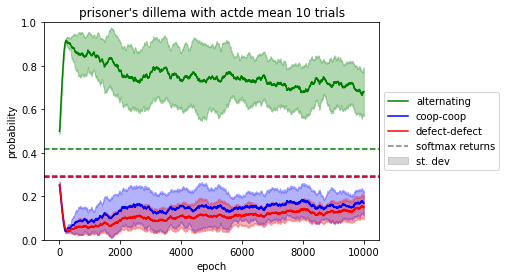

In [117]:
import matplotlib.pyplot as plt
import numpy as np

alg_name = train_config.alg_name
if alg_name == "reject":
    alg_name = "rejection sampling"

minEp = 0
maxEp = 6400
stride = 1

plt.figure()
title = f"prisoner's dillema with {alg_name} mean 10 trials"
plt.title(title)
plt.ylabel("probability")
plt.xlabel("epoch")
for k in rew_dict_named:
    plt.plot(iter_list[minEp:maxEp:stride], mean_rew_dict[k][minEp:maxEp:stride], label=k, color=colors[k], marker="")

    # std ribbon
    upperbound = [mean_rew_dict[k][i] + std_rew_dict[k][i] for i in range(len(iter_list))]
    lowerbound = [mean_rew_dict[k][i] - std_rew_dict[k][i] for i in range(len(iter_list))]

    plt.fill_between(iter_list[minEp:maxEp:stride], lowerbound[minEp:maxEp:stride], upperbound[minEp:maxEp:stride], color=colors[k], alpha=0.3)

# horizontal dashed line of each softmax returns
plt.axhline(y=softmax_returns[0], color=colors["coop-coop"], linestyle='--')
plt.axhline(y=softmax_returns[1], color=colors["defect-defect"], linestyle='--')
plt.axhline(y=softmax_returns[2], color=colors["alternating"], linestyle='--')

plt.ylim(0, 1)
# out of bound line to add a gray dash to legend
plt.axhline(y=-1, color="gray", linestyle='--', label="softmax returns")
plt.fill_between([-1], [-1], [-1], color="gray", alpha=0.3, label="st. dev")


plt.legend(loc='center left', 
           bbox_to_anchor=(1, 0.5))
plt.savefig(alg_name + ".jpg", bbox_inches='tight', dpi=500)
plt.show()